In [ ]:
import os
import torch
from PIL import Image
from ultralytics import YOLO
from torchvision import models, transforms
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage
import clip
import logging

logging.basicConfig(level=logging.INFO)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
yolo_model = YOLO("yolov8n.pt")
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
resnet = models.resnet18(pretrained=True).to(device).eval()
ollama = ChatOllama(model="granite3-dense:2b", temperature=0)
with open("Vid/imagenet_classes.txt") as f:
    imagenet_labels = [line.strip() for line in f.readlines()]

In [ ]:
def detect_objects_yolo(image_path):
    results = yolo_model(image_path)
    names = results[0].names
    boxes = results[0].boxes
    if boxes is None or len(boxes) == 0:
        return []
    return list(set([names[int(cls)] for cls in boxes.cls]))

In [ ]:
def generate_clip_labels(image_path, candidate_labels):
    image = clip_preprocess(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)
    text = clip.tokenize([f"a photo of a {label}" for label in candidate_labels]).to(device)
    with torch.no_grad():
        image_features = clip_model.encode_image(image)
        text_features = clip_model.encode_text(text)
        logits_per_image, _ = clip_model(image, text)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()[0]
    top_indices = probs.argsort()[-7:][::-1]
    return [candidate_labels[i] for i in top_indices if probs[i] > 0.1]

In [ ]:
def classify_with_resnet(image_path):
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    image = preprocess(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = resnet(image)
        _, predicted = outputs.topk(5, 1, True, True)
    return [imagenet_labels[idx] for idx in predicted[0]]

In [ ]:
def summarize_with_granite(labels):
    prompt = (
        "Generate a brief and meaningful description of an image based on the following detected or inferred labels:\n"
        + ", ".join(labels) +
        "\nKeep it visual, natural, and globally understandable."
    )
    return ollama.invoke([HumanMessage(content=prompt)]).content.strip()

In [ ]:
def summarize_image(image_path):
    logging.info(f" Processing image: {image_path}")
    
    yolo_labels = detect_objects_yolo(image_path)
    logging.info(f"YOLO detected: {yolo_labels}")

    if yolo_labels:
        clip_labels = generate_clip_labels(image_path, yolo_labels)
        logging.info(f"CLIP labels: {clip_labels}")
    else:
        clip_labels = []

    if not clip_labels and not yolo_labels:
        resnet_labels = classify_with_resnet(image_path)
        logging.info(f"ResNet fallback labels: {resnet_labels}")
        final_labels = resnet_labels
    else:
        final_labels = clip_labels if clip_labels else yolo_labels

    summary = summarize_with_granite(final_labels)
    logging.info("Summary:\n" + summary)
    print("\n Summary:")
    print(summary)

if __name__ == "__main__":
    image_path = "C://Users//prana//Downloads//ChatGPT Image Mar 30, 2025, 05_09_24 PM.png"  # Replace with any image path
    summarize_image(image_path)

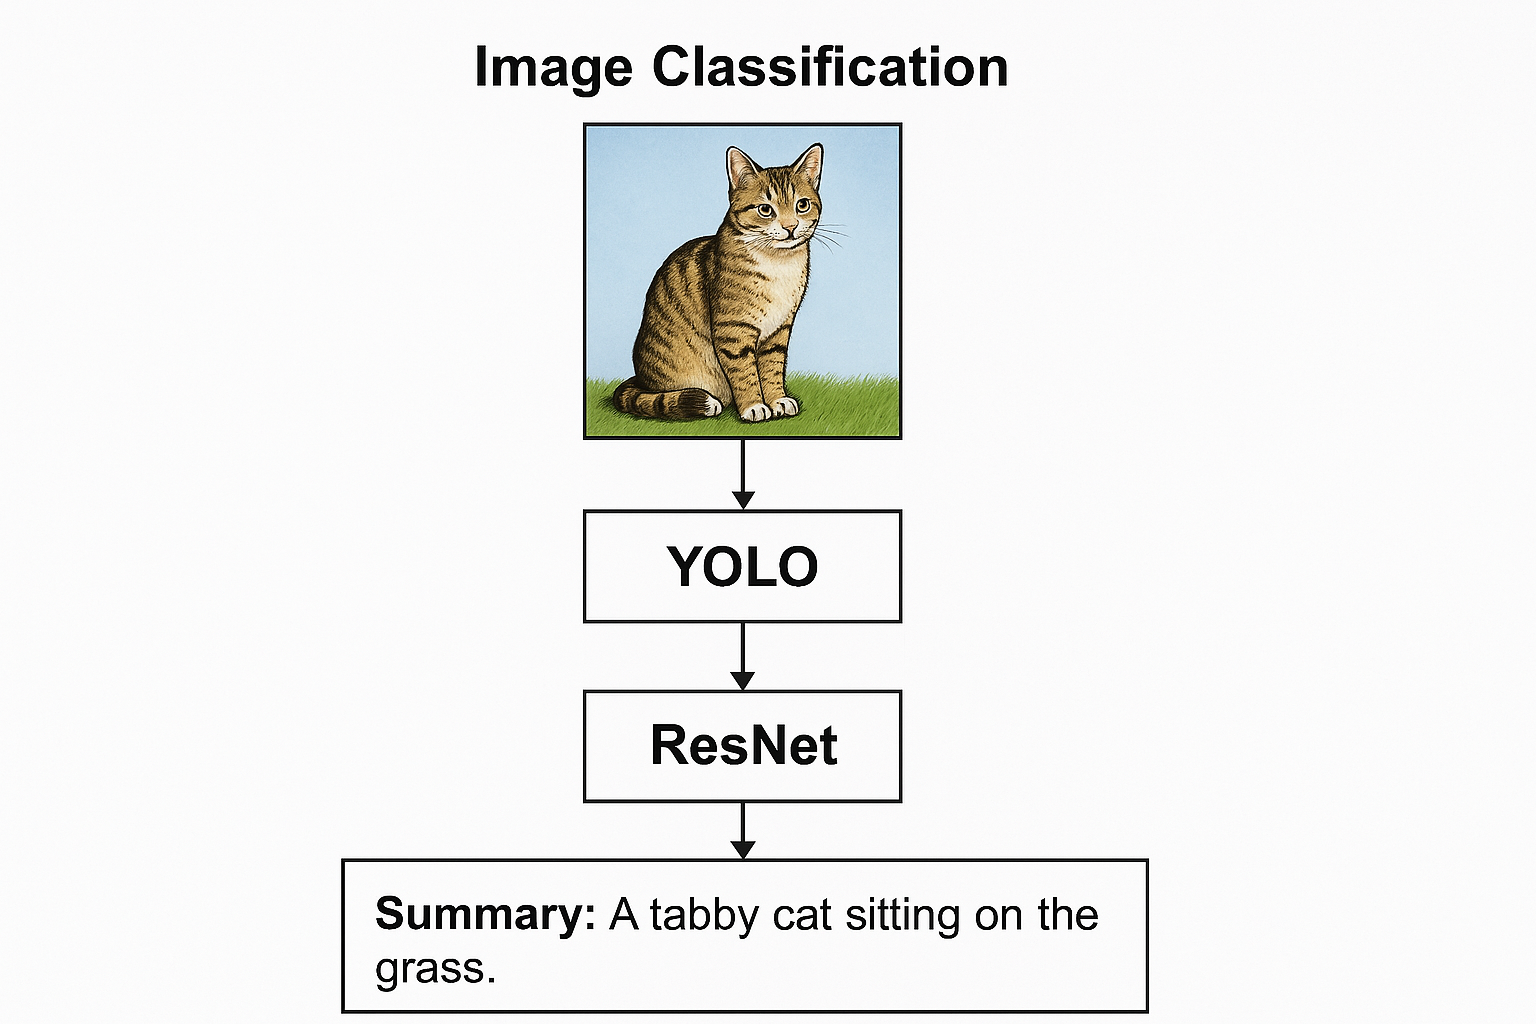